<h1>Astro 283 Homework 6</h1>
Bijan Pourhamzeh


In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import iv
from scipy.optimize import fmin
from csv import reader
from astropy.io import fits

from __future__ import print_function

<h3> Problem 1 </h3>

In [37]:
#Read in student samples

samples = reader(open('rice.dat', 'rt'))
x_dat = []
for sam in samples:
    x_dat.append(float(sam[0]))
    
x_dat = np.array(x_dat)
print(x_dat)

[  7.893145   12.87092    17.9159      0.4349276   0.3306195   2.932549
  23.8691      3.448594    7.779337    0.3736466   3.784709    2.782
  17.8508      2.528774    2.853153   23.90128    13.02464     0.6660353
   1.794565   18.14342     1.376215    2.798997    6.412296   29.86244
   7.839873    6.570388    0.2057757   3.163097   11.91203    12.5479
   1.469301   12.02533     0.7435214   1.707394    1.048436    7.447414
   1.359778    6.859517    6.13546     2.64491    29.92344    12.15828
   7.446064    0.8170959   2.124207    2.968172    6.390549    0.6565358
   7.063244    2.490683 ]


In [35]:
def rice_likelihood(params, x):
    return 1/params[0]*np.exp(-(x+params[1])/params[0])*iv(0,2*np.sqrt(x*params[1])/params[0])

neg_RL = lambda params, x: -1*np.prod(rice_likelihood(params,x))

In [41]:
initial = np.array([5,0])
opt_r = fmin(neg_RL, initial, args=(x_dat,))

print(opt_r)

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 29
         Function evaluations: 55
[  7.22612374e+00   7.86827536e-04]


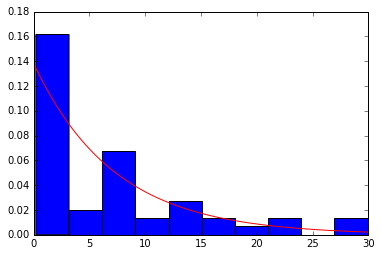

In [42]:
plt.hist(x_dat, normed=True)

x_vals = np.arange(0,30,.01)
plt.plot(x_vals, rice_likelihood(opt_r,x_vals), 'r-')

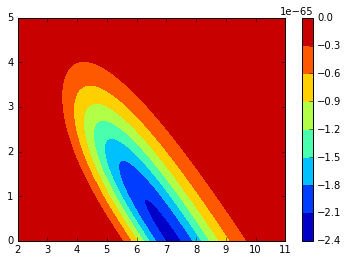

In [40]:
alp = np.linspace(2,11,100)
bet = np.linspace(0,5,100)
prob = np.array([[neg_RL((a,b),x_dat) for a in alp] for b in bet])
plt.contourf(alp, bet, prob)
plt.colorbar()

<h3>Problem 2</h3>

(128L, 128L, 128L)


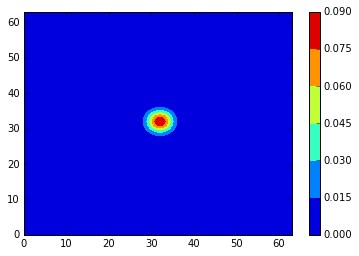

In [6]:
model_file = fits.open('../../hw6prob2_model.fits')
model_data = model_file[0].data
print(model_data.shape)

psf_file = fits.open('../../hw6prob2_psf.fits')
psf_data = psf_file[0].data
plt.contourf(psf_data)
plt.colorbar()

(128L, 128L)


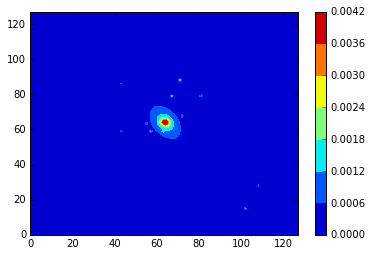

In [7]:
model_int = np.sum(model_data, axis=0)
print(model_int.shape)
plt.contourf(model_int)
plt.colorbar()

In [18]:
#from timeit import timeit

def my_fft_1d(a, inverse=False):
    '''Computes a fast fourier transform of a 1d array, a. 
    Returns a complex array of the same size. Uses the Cooley-Tukey algorithm'''
    
    n = len(a)
    out = [0]*n
    
    if inverse:
        s = -1
    else:
        s = 1
        
    if n == 1:
        out[0] = a[0]
    else:
        out[0:int(n/2)] = my_fft_1d(a[0::2])
        out[int(n/2):] = my_fft_1d(a[1::2])
        for k in range(0,int(n/2)):
            t = out[k]
            out[k] = t + np.exp(-s*2*np.pi*1j*k/n)*out[k+int(n/2)]
            out[k+int(n/2)] = t - np.exp(-s*2*np.pi*1j*k/n)*out[k+int(n/2)]
    return out

In [53]:
def my_fft_2d(a, inverse=False):
    '''Computes a fast fourier transform of a 2d array, a. 
    Returns a complex array of the same size. Uses the Cooley-Tukey algorithm'''
    
    a = np.array(a)
    
    n1, n2 = a.shape
    if n1 != n2:
        print('Input must be a square array! Shape is', (n1,n2))
        return None
    N = n1
    N2 = int(N/2)
    out = np.zeros((N,N), dtype=complex)
    
    if inverse:
        s = -1
    else:
        s = 1
        
    if N == 1:
        out[0,0] = a[0,0]
    else:
        out[0:N2,0:N2] = my_fft_2d(a[0::2,0::2])
        out[N2:,0:N2] = my_fft_2d(a[1::2,0::2])
        out[0:N2,N2:] = my_fft_2d(a[0::2,1::2])
        out[N2:,N2:] = my_fft_2d(a[1::2,1::2])
        for k1 in range(0,N2):
            for k2 in range(0,N2):
                t = out[k1,k2]
                tw1 = np.exp(-s*2*np.pi*1j*k1/N)
                tw2 = np.exp(-s*2*np.pi*1j*k2/N)
                out[k1,k2] = t + tw1*out[k1+N2,k2] + tw2*out[k1,k2+N2] + tw1*tw2*out[k1+N2,k2+N2]
                out[k1+N2,k2] = t - tw1*out[k1+N2,k2] + tw2*out[k1,k2+N2] - tw1*tw2*out[k1+N2,k2+N2]
                out[k1,k2+N2] = t + tw1*out[k1+N2,k2] - tw2*out[k1,k2+N2] - tw1*tw2*out[k1+N2,k2+N2]
                out[k1+N2,k2+N2] = t - tw1*out[k1+N2,k2] - tw2*out[k1,k2+N2] + tw1*tw2*out[k1+N2,k2+N2]
    return out

In [54]:
model_int_f = my_fft_2d(model_int)
psf_data_f = my_fft_2d(psf_data)

array([[-0.13674950 +5.51188598e-02j, -0.14258245 -2.57377153e-01j,
        -1.63765101 -4.37186583e-01j,  1.29830525 +1.68876583e-01j],
       [-0.00479613 -5.60695270e-02j,  0.45414875 +1.14215542e-01j,
         1.80079465 +2.36865210e-01j, -1.39619939 +2.87287805e-01j],
       [ 0.24326638 +6.12379084e-02j, -0.45152287 -6.63278777e-02j,
         1.87502747 +0.00000000e+00j, -1.31056799 -2.48125650e-02j],
       [-0.06072156 +1.75018487e-01j,  0.04974912 -1.32128870e-01j,
        -1.81241147 -1.80240312e-06j, -0.27520405 -7.33979798e-01j]])

In [52]:
a=np.zeros((2,2),dtype=complex)